In [1]:
import os
import numpy as np
import pandas as pd

In [3]:
def extract_features_from_file(file_path):
    """
    Extracts features from a single annotation file.
    :param file_path: Path to the annotation file.
    :return: List of extracted feature rows.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract fall labels from the first two lines
    try:
        fall_start, fall_end = map(int, lines[:2])  # Convert to int safely
        is_fall = 1 if (fall_start, fall_end) != (0, 0) else 0
    except ValueError:
        print(f"Warning: Skipping file {file_path} due to malformed first two lines.")
        return []
    
    # Process bounding box data
    feature_rows = []
    prev_center_x, prev_center_y = None, None
    prev_velocity_x, prev_velocity_y = None, None
    
    for line in lines[2:]:
        line = line.strip()
        if not line:  # Skip empty lines
            continue
        
        parts = line.split(',')
        if len(parts) < 6:
            print(f"Warning: Skipping malformed line in {file_path}: {line}")
            continue  # Skip malformed lines
        
        try:
            frame, person_id, x_min, y_min, x_max, y_max = map(int, parts)
        except ValueError:
            print(f"Warning: Non-numeric values found in {file_path}: {line}")
            continue  # Skip lines with invalid numeric values

        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        aspect_ratio = width / height if height != 0 else 0  # Avoid division by zero
        
        # Compute velocity
        velocity_x = (center_x - prev_center_x) if prev_center_x is not None else 0
        velocity_y = (center_y - prev_center_y) if prev_center_y is not None else 0
        
        # Compute acceleration
        acceleration_x = (velocity_x - prev_velocity_x) if prev_velocity_x is not None else 0
        acceleration_y = (velocity_y - prev_velocity_y) if prev_velocity_y is not None else 0
        
        feature_rows.append([file_path, frame, center_x, center_y, aspect_ratio,
                             velocity_x, velocity_y, acceleration_x, acceleration_y, is_fall])
        
        prev_center_x, prev_center_y = center_x, center_y
        prev_velocity_x, prev_velocity_y = velocity_x, velocity_y
    
    return feature_rows

In [4]:
def process_all_annotation_files(folder_path):
    """
    Processes all annotation files and compiles extracted features into a CSV file.
    :param folder_path: Path to the folder containing annotation files.
    """
    all_features = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_path, file_name)
            features = extract_features_from_file(file_path)
            all_features.extend(features)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_features, columns=[
        'file_name', 'frame', 'center_x', 'center_y', 'aspect_ratio',
        'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y', 'fall_label'
    ])
    
    # Save to CSV
    output_csv = os.path.join(folder_path, "extracted_features.csv")
    df.to_csv(output_csv, index=False)
    print(f"Feature extraction complete. Data saved to {output_csv}")
    
    return df


In [5]:
folder_path = "C:/Users/Admin/Desktop/nofall/annotation_files"
dataset = process_all_annotation_files(folder_path)

Feature extraction complete. Data saved to C:/Users/Admin/Desktop/nofall/annotation_files\extracted_features.csv


In [7]:
def extract_fall_moments(file_path):
    """
    Extracts features only for fall moments from an annotation file.
    :param file_path: Path to the annotation file.
    :return: List of extracted feature rows.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract fall start and end frames from the first two lines
    try:
        fall_start, fall_end = map(int, lines[:2])
        is_fall = 1 if (fall_start, fall_end) != (0, 0) else 0
    except ValueError:
        print(f"Warning: Skipping file {file_path} due to malformed first two lines.")
        return []
    
    feature_rows = []
    prev_center_x, prev_center_y = None, None
    prev_velocity_x, prev_velocity_y = None, None
    
    for line in lines[2:]:
        line = line.strip()
        if not line:
            continue
        
        parts = line.split(',')
        if len(parts) < 6:
            print(f"Warning: Skipping malformed line in {file_path}: {line}")
            continue
        
        try:
            frame, person_id, x_min, y_min, x_max, y_max = map(int, parts)
        except ValueError:
            print(f"Warning: Non-numeric values found in {file_path}: {line}")
            continue
        
        # If fall is detected, only record frames within the fall range
        if is_fall and not (fall_start <= frame <= fall_end):
            continue
        
        center_x = (x_min + x_max) / 2
        center_y = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        aspect_ratio = width / height if height != 0 else 0  # Avoid division by zero
        
        # Compute velocity
        velocity_x = (center_x - prev_center_x) if prev_center_x is not None else 0
        velocity_y = (center_y - prev_center_y) if prev_center_y is not None else 0
        
        # Compute acceleration
        acceleration_x = (velocity_x - prev_velocity_x) if prev_velocity_x is not None else 0
        acceleration_y = (velocity_y - prev_velocity_y) if prev_velocity_y is not None else 0
        
        feature_rows.append([file_path, frame, center_x, center_y, aspect_ratio,
                             velocity_x, velocity_y, acceleration_x, acceleration_y, is_fall])
        
        prev_center_x, prev_center_y = center_x, center_y
        prev_velocity_x, prev_velocity_y = velocity_x, velocity_y
    
    return feature_rows

In [8]:
def process_all_annotation_files2(folder_path):
    """
    Processes all annotation files and compiles extracted features into a CSV file.
    :param folder_path: Path to the folder containing annotation files.
    """
    all_features = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".txt"):
            file_path = os.path.join(folder_path, file_name)
            features = extract_fall_moments(file_path)
            all_features.extend(features)
    
    # Convert to DataFrame
    df = pd.DataFrame(all_features, columns=[
        'file_name', 'frame', 'center_x', 'center_y', 'aspect_ratio',
        'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y', 'fall_label'
    ])
    
    # Save to CSV
    output_csv = os.path.join(folder_path, "extracted_fall_moments.csv")
    df.to_csv(output_csv, index=False)
    print(f"Feature extraction complete. Data saved to {output_csv}")
    
    return df

In [9]:
folder_path = "C:/Users/Admin/Desktop/fall/annotation_files"
dataset = process_all_annotation_files2(folder_path)

Feature extraction complete. Data saved to C:/Users/Admin/Desktop/fall/annotation_files\extracted_fall_moments.csv


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc

In [11]:
def plot_learning_curve(model, X, y):
    """Plots the learning curve of the SVM model."""
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    
    plt.figure()
    plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
    plt.plot(train_sizes, test_mean, 'o-', label='Validation Accuracy')
    plt.xlabel("Training Samples")
    plt.ylabel("Accuracy")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
def plot_roc_curve(y_test, y_pred_prob):
    """Plots the ROC curve and computes AUC."""
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.grid()
    plt.show()

In [13]:
def train_and_evaluate_svm(fall_csv, no_fall_csv):
    """
    Loads fall and no-fall datasets, splits them into train/test sets, trains an SVM model, and evaluates it.
    :param fall_csv: Path to CSV file containing fall case features.
    :param no_fall_csv: Path to CSV file containing no-fall case features.
    """
    # Load datasets
    df_fall = pd.read_csv(fall_csv)
    df_no_fall = pd.read_csv(no_fall_csv)
    
    # Combine both datasets
    df = pd.concat([df_fall, df_no_fall], ignore_index=True)
    
    # Select features and labels
    X = df[['center_x', 'center_y', 'aspect_ratio', 'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y']]
    y = df['fall_label']
    
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Train SVM model
    model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True)
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    
    # Evaluation
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"Model Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    
    # Plot learning curve
    plot_learning_curve(model, X, y)
    
    # Plot ROC curve
    plot_roc_curve(y_test, y_pred_prob)
    
    return model

Model Accuracy: 0.9584
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       459
           1       0.99      0.92      0.95       406

    accuracy                           0.96       865
   macro avg       0.96      0.96      0.96       865
weighted avg       0.96      0.96      0.96       865



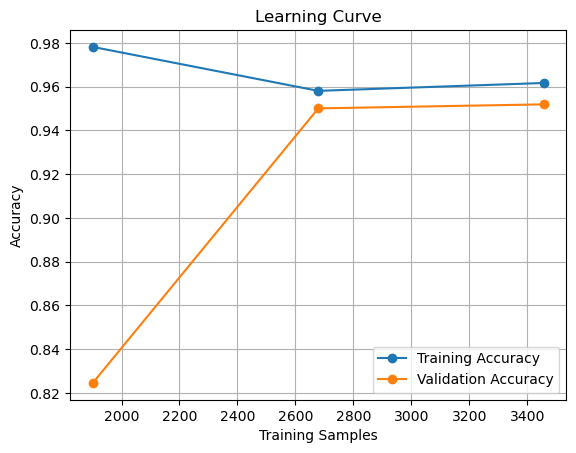

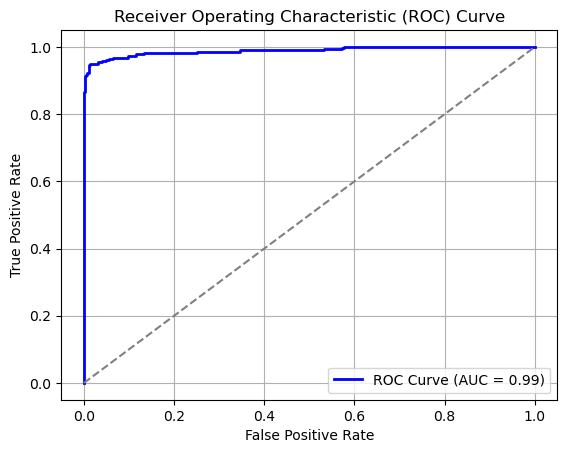

In [16]:
fall_csv = "fall_moments.csv"
no_fall_csv = "no_fall_moments.csv"
model = train_and_evaluate_svm(fall_csv, no_fall_csv)

In [17]:
import joblib 
from sklearn.preprocessing import StandardScaler

In [18]:
joblib.dump(model, 'svc_model.pkl')

['svc_model.pkl']

In [19]:
svc_model = joblib.load('svc_model.pkl')

In [20]:
features = extract_features_from_file("video1.txt")

In [21]:
columns = ['file_name', 'frame', 'center_x', 'center_y', 'aspect_ratio',
           'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y', 'is_fall']
df = pd.DataFrame(features, columns=columns)

In [22]:
X = df[['center_x', 'center_y', 'aspect_ratio', 'velocity_x', 'velocity_y', 'acceleration_x', 'acceleration_y']]

In [23]:
predictions = svc_model.predict(X)

In [24]:
df['predicted_fall'] = predictions
fall_detected = any(predictions == 1)

In [25]:
print(df[['frame', 'predicted_fall']].head())
print("\nFALL DETECTED" if fall_detected else "\nNO FALL detected")

   frame  predicted_fall
0      1               0
1      2               0
2      3               0
3      4               0
4      5               0

NO FALL detected
